In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**The problem statement** : We need to find a governing
ordinary differential equation for the rates of change of
x1 and x2. But the earlier section also says that the populations of Leopanet and Paldore depend on each other, that is x1 and x2 do depend on each other.

**Given** : The populations of x1 and x2, their values varying with a constant unit of time. For this, I have assumed a time unit value of 0.1 for simplicity

**To find** : $\frac{dx_1}{dt}$ and $\frac{dx_2}{dt}$ as a function of linear and non-linear terms of the second order

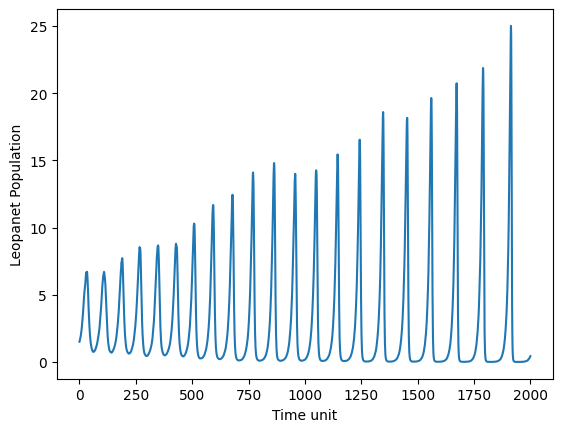

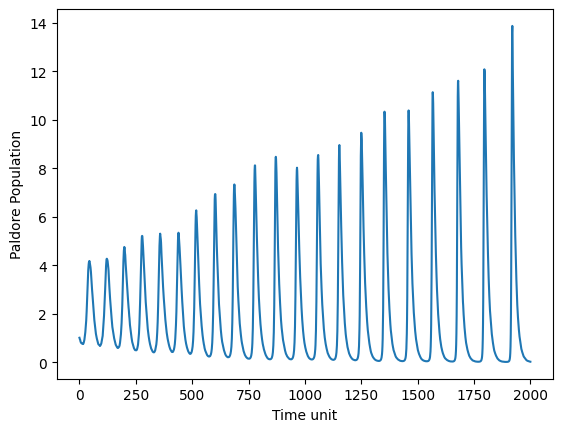

In [4]:
data = pd.read_csv("23.csv")           # Insert file path of the csv

plt.plot(data["x1"])
plt.ylabel("Leopanet Population")
plt.xlabel("Time unit")
plt.show()

plt.plot(data["x2"])
plt.ylabel("Paldore Population")
plt.xlabel("Time unit")
plt.show()

The data looks very clean, so no outlier treatment is required.

**Given Variables** : $x_{1}, x_{2}, time$



**Proposed Hypothesis**

$$
\frac{dx_1}{dt} = A + Bt + Ct^{2} + Dx_{1} + Ex_{1}^{2} + Fx_{2} + Gx_{2}^{2} + Hx_{1}x_{2}
$$
Similarly, for $x_{2}$

$$
\frac{dx_2}{dt} = A + Bt + Ct^{2} + Dx_{1} + Ex_{1}^{2} + Fx_{2} + Gx_{2}^{2} + Hx_{1}x_{2}
$$

(different values of coefficients for both the equations)

**The Approach** :


*   Calculate time derivates of $x_{1}$ and $x_{2}$, and also the other required features present in the above hypothesis. By the central difference theorem,

$$
f'(x_{1}^{[t]}) = \frac{f(x_{1}^{[t + 1]}) - f(x_{1}^{[t - 1]})}{2t}
$$
> where $x_{1}^{[t]}$ is the value of $x_{1}$ at time t

*   Build a MLR Model on all the features generated, and validate it's performance through the $R^{2}$ values, annd fiind the final governing ODEs





---



**Pseudocode of the Approach** :


1.   Initialise Dataset, define time unit (0.1 in this case)
2.   Find time derivatives using Central Difference Method, and add to the Dataset
3. Calculate all other required features
4. Split dataset into train and test
5. Build an MLR Model on train data to find coefficients using sklearn
5. Verify final solution on test data



In [5]:
# Adding the time attribute

entries = data.shape[0]

time = 0.1 * np.array(range(entries))         # To get time values (0.1 chosen as time step)
data["t"] = time

# Adding the rest of the features, as defined above

data["const"] = np.ones(entries)
data["t2"] = time ** 2
data["x12"] = data["x1"] ** 2
data["x22"] = data["x2"] ** 2
data["x1x2"] = data["x1"] * data["x2"]

data.head()

,x1,x2,t,const,t2,x12,x22,x1x2
0,1.504905,1.009315,0.0,1.0,0.00,2.264738,1.018717,1.518923
1,1.567239,0.968654,0.1,1.0,0.01,2.456239,0.938291,1.518113
2,1.629781,0.944930,0.2,1.0,0.04,2.656188,0.892893,1.540030
3,1.718278,0.928612,0.3,1.0,0.09,2.952480,0.862321,1.595614
4,1.786206,0.878851,0.4,1.0,0.16,3.190533,0.772378,1.569808


Now we have all the features, we can calculate the rate changes for prediction

Since we cannot find rates of changes for the first and last entry of the data, I am omitting them from the final model training for better results


In [6]:
x1_t = [0] # Initialising these lists with 0, to omit this value later
x2_t = [0]
for i in range(1, entries - 1):
  der_x1 = (data.loc[i + 1, "x1"] - data.loc[i - 1, "x1"]) / 0.2
  der_x2 = (data.loc[i + 1, "x2"] - data.loc[i - 1, "x2"]) / 0.2
  x1_t.append(der_x1)
  x2_t.append(der_x2)
x1_t.append(0)
x2_t.append(0)    # Adding a final zero to match the data size

# Adding the derivatives to the overall dataset

data["x1_t"] = x1_t
data["x2_t"] = x2_t

# Preview of the final dataset

data.tail()

,x1,x2,t,const,t2,x12,x22,x1x2,x1_t,x2_t
1996,0.292694,0.028106,199.6,1.0,39840.16,0.085670,0.000790,0.008226,0.303132,-0.023165
1997,0.321357,0.025832,199.7,1.0,39880.09,0.103270,0.000667,0.008301,0.302738,-0.022893
1998,0.353242,0.023527,199.8,1.0,39920.04,0.124780,0.000554,0.008311,0.333630,-0.017232
1999,0.388083,0.022385,199.9,1.0,39960.01,0.150609,0.000501,0.008687,0.392708,-0.012344
2000,0.431783,0.021059,200.0,1.0,40000.00,0.186437,0.000443,0.009093,0.000000,0.000000


Now we have the complete required dataset, we can start building the training and testing data

For splitting the time series into training and testing, we can choose the first x% of the data to train the model, and the rest (100-x)% for the testing. Since we require 3 different splits in total, I have considered :

*   50 - 50 Train : Test
*   60 - 40 Train : Test
*   70 - 30 Train : Test



In [7]:
# Defining the targets and the features

data_x1_feat = data.loc[1:entries - 2, ["const", "t", "t2", "x1", "x12", "x2", "x22", "x1x2"]]
data_x1_target = data.loc[1:entries - 2, ["x1_t"]]

data_x2_feat = data.loc[1:entries - 2, ["const", "t", "t2", "x1", "x12", "x2", "x22", "x1x2"]]
data_x2_target = data.loc[1:entries - 2, ["x2_t"]]

# 50 - 50 Split first
split = entries // 2

x1_feat_train1, x1_tar_train1 = data_x1_feat.loc[:split], data_x1_target.loc[:split]
x1_feat_test1, x1_tar_test1 = data_x1_feat.loc[split + 1:], data_x1_target.loc[split + 1:]

x2_feat_train1, x2_tar_train1 = data_x2_feat.loc[:split], data_x2_target.loc[:split]
x2_feat_test1, x2_tar_test1 = data_x2_feat.loc[split + 1:], data_x2_target.loc[split + 1:]

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

x1_model1 = LinearRegression()
x2_model1 = LinearRegression()

x1_model1.fit(x1_feat_train1, x1_tar_train1)
x2_model1.fit(x2_feat_train1, x2_tar_train1)

LinearRegression()

In [9]:
pred_x1 = x1_model1.predict(x1_feat_test1)
r2_x1_50 = r2_score(x1_tar_test1, pred_x1)

pred_x2 = x2_model1.predict(x2_feat_test1)
r2_x2_50 = r2_score(x2_tar_test1, pred_x2)


print(f"R-squared for 50-50 split dx1/dt = {r2_x1_50}")
print(f"R-squared for 50-50 split dx2/dt = {r2_x2_50}")


R-squared for 50-50 split dx1/dt = 0.9952425722303693
R-squared for 50-50 split dx2/dt = 0.9961491768710913


So we have very good $R^2$ values for both the predictions even with 50-50 train test split

Now, building different models for 60-40 split and 80-20 split

In [10]:
# 60 - 40 Split
# Same code as above, only changing split value

split = entries * 0.6

x1_feat_train2, x1_tar_train2 = data_x1_feat.loc[:split], data_x1_target.loc[:split]
x1_feat_test2, x1_tar_test2 = data_x1_feat.loc[split + 1:], data_x1_target.loc[split + 1:]

x2_feat_train2, x2_tar_train2 = data_x2_feat.loc[:split], data_x2_target.loc[:split]
x2_feat_test2, x2_tar_test2 = data_x2_feat.loc[split + 1:], data_x2_target.loc[split + 1:]

x1_model2 = LinearRegression()
x2_model2 = LinearRegression()

x1_model2.fit(x1_feat_train2, x1_tar_train2)
x2_model2.fit(x2_feat_train2, x2_tar_train2)

pred_x1 = x1_model2.predict(x1_feat_test2)
r2_x1_60 = r2_score(x1_tar_test2, pred_x1)

pred_x2 = x2_model2.predict(x2_feat_test2)
r2_x2_60 = r2_score(x2_tar_test2, pred_x2)


print(f"R-squared for 60-40 split dx1/dt = {r2_x1_60}")
print(f"R-squared for 60-40 split dx2/dt = {r2_x2_60}")

R-squared for 60-40 split dx1/dt = 0.9968939301410269
R-squared for 60-40 split dx2/dt = 0.997377092691851


In [11]:
# 70 - 30 Split
# Same code as above, only changing split value

split = entries * 0.7

x1_feat_train3, x1_tar_train3 = data_x1_feat.loc[:split], data_x1_target.loc[:split]
x1_feat_test3, x1_tar_test3 = data_x1_feat.loc[split + 1:], data_x1_target.loc[split + 1:]

x2_feat_train3, x2_tar_train3 = data_x2_feat.loc[:split], data_x2_target.loc[:split]
x2_feat_test3, x2_tar_test3 = data_x2_feat.loc[split + 1:], data_x2_target.loc[split + 1:]

x1_model3 = LinearRegression()
x2_model3 = LinearRegression()

x1_model3.fit(x1_feat_train3, x1_tar_train3)
x2_model3.fit(x2_feat_train3, x2_tar_train3)

pred_x1 = x1_model3.predict(x1_feat_test3)
r2_x1_70 = r2_score(x1_tar_test3, pred_x1)

pred_x2 = x2_model3.predict(x2_feat_test3)
r2_x2_70 = r2_score(x2_tar_test3, pred_x2)


print(f"R-squared for 70-30 split dx1/dt = {r2_x1_70}")
print(f"R-squared for 70-30 split dx2/dt = {r2_x2_70}")

R-squared for 70-30 split dx1/dt = 0.9974941502110517
R-squared for 70-30 split dx2/dt = 0.9973640609187173


In [12]:
r2_values = pd.DataFrame({"50-50 Split" : (r2_x1_50, r2_x2_50), "60-40 Split" : (r2_x1_60, r2_x2_60), "70-30 Split" : (r2_x1_70, r2_x2_70)}, index = ["R2 for x1", "R2 for x2"])
r2_values

,50-50 Split,60-40 Split,70-30 Split
R2 for x1,0.995243,0.996894,0.997494
R2 for x2,0.996149,0.997377,0.997364


From the $R^2$ values, we can judge that the 70-30 Split works best for the x1 predictions, and 60-40 split works best for the x2 predictions



---

Now plotting the predicted and actual values



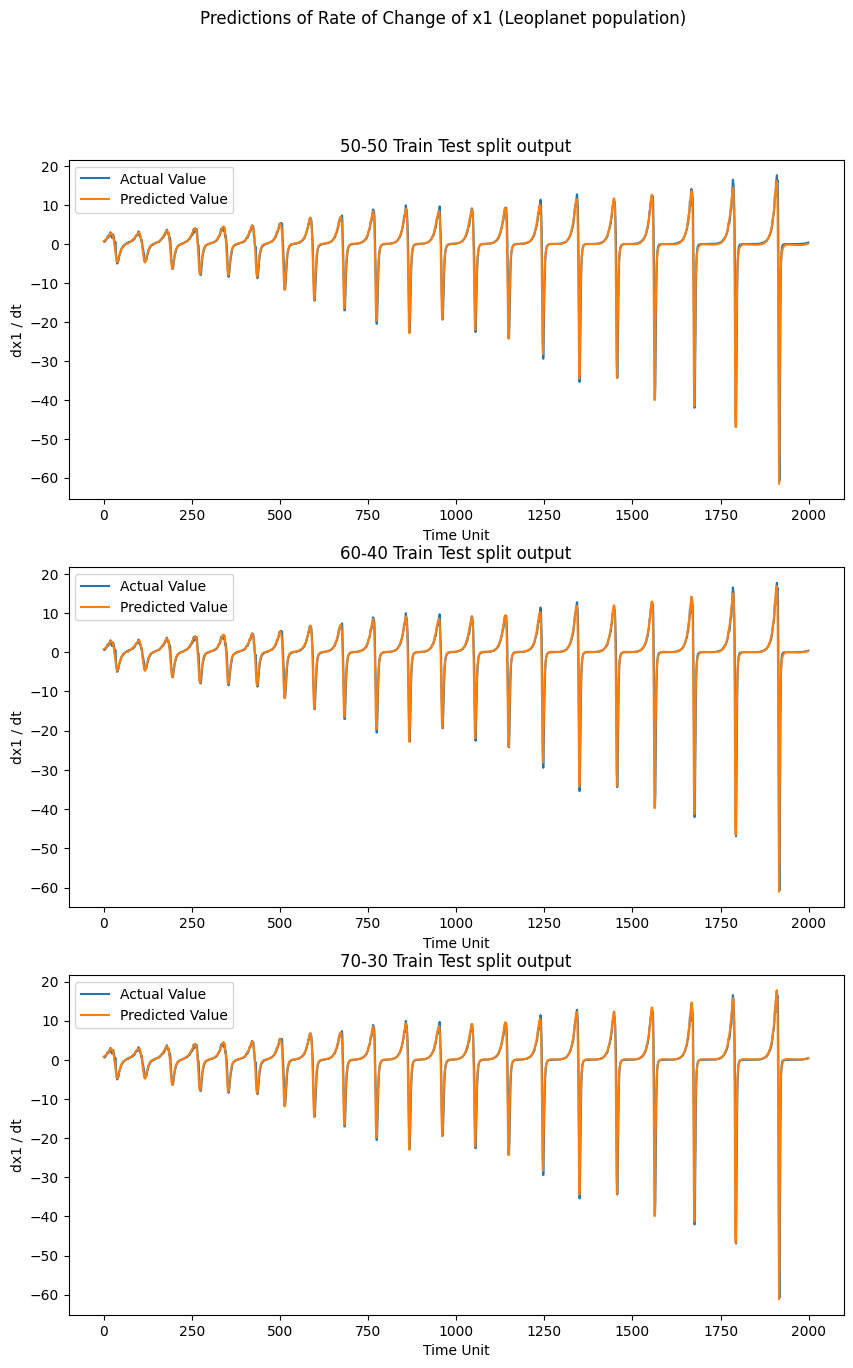

In [13]:
# dx1 / dt values
figure, (x1_50, x1_60, x1_70) = plt.subplots(3, 1, figsize = (10, 15))
plt.suptitle("Predictions of Rate of Change of x1 (Leoplanet population)")

x1_50.plot(data_x1_target, label = "Actual Value")
x1_50.plot(x1_model1.predict(data_x1_feat), label = "Predicted Value")
x1_50.set_xlabel("Time Unit")
x1_50.set_ylabel("dx1 / dt")
x1_50.legend()
x1_50.set_title("50-50 Train Test split output")

x1_60.plot(data_x1_target, label = "Actual Value")
x1_60.plot(x1_model2.predict(data_x1_feat), label = "Predicted Value")
x1_60.set_xlabel("Time Unit")
x1_60.set_ylabel("dx1 / dt")
x1_60.legend()
x1_60.set_title("60-40 Train Test split output")

x1_70.plot(data_x1_target, label = "Actual Value")
x1_70.plot(x1_model3.predict(data_x1_feat), label = "Predicted Value")
x1_70.set_xlabel("Time Unit")
x1_70.set_ylabel("dx1 / dt")
x1_70.legend()
x1_70.set_title("70-30 Train Test split output")

plt.show()

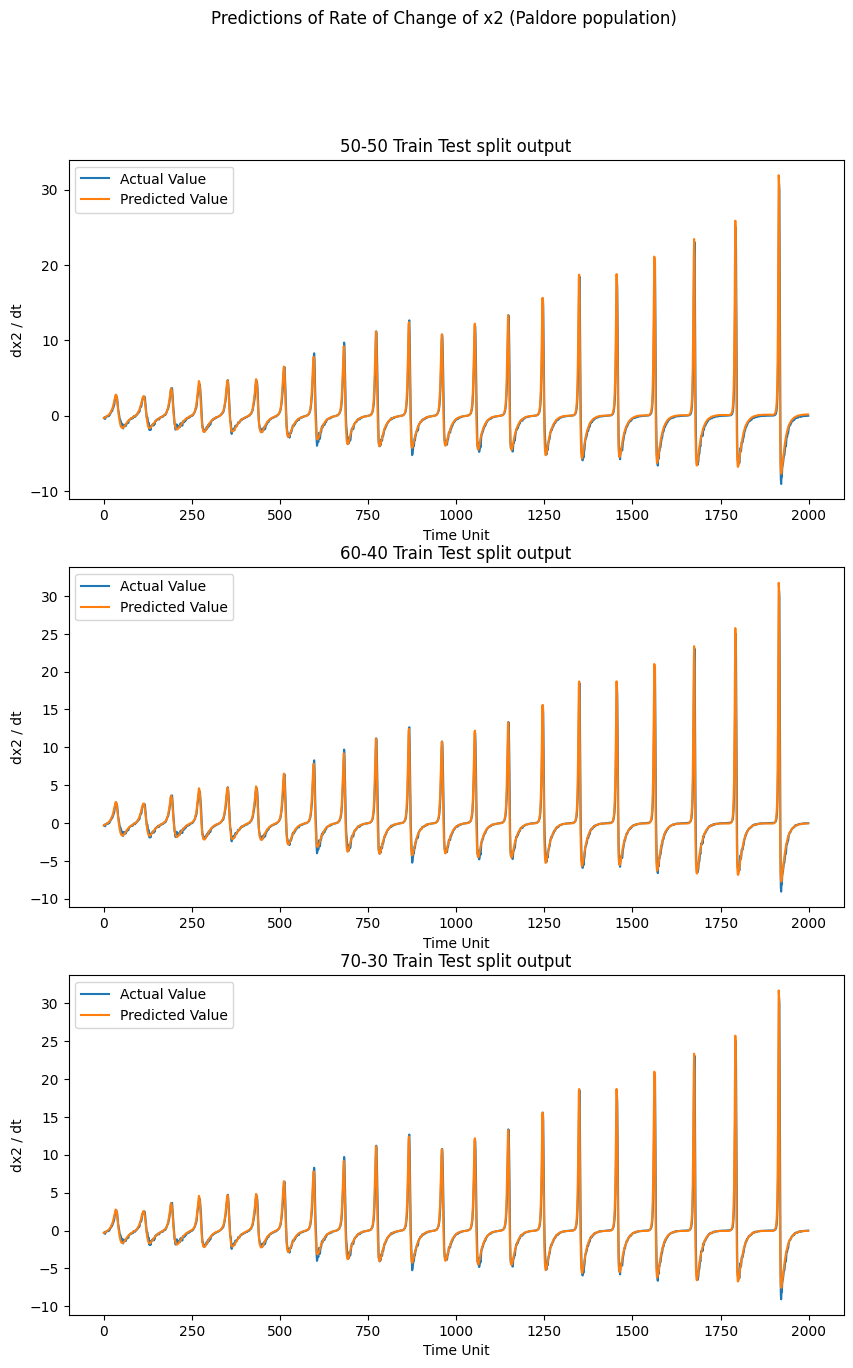

In [14]:
# dx2 / dt values
figure, (x2_50, x2_60, x2_70) = plt.subplots(3, 1, figsize = (10, 15))
plt.suptitle("Predictions of Rate of Change of x2 (Paldore population)")

x2_50.plot(data_x2_target, label = "Actual Value")
x2_50.plot(x2_model1.predict(data_x2_feat), label = "Predicted Value")
x2_50.set_xlabel("Time Unit")
x2_50.set_ylabel("dx2 / dt")
x2_50.legend()
x2_50.set_title("50-50 Train Test split output")

x2_60.plot(data_x2_target, label = "Actual Value")
x2_60.plot(x2_model2.predict(data_x2_feat), label = "Predicted Value")
x2_60.set_xlabel("Time Unit")
x2_60.set_ylabel("dx2 / dt")
x2_60.legend()
x2_60.set_title("60-40 Train Test split output")

x2_70.plot(data_x2_target, label = "Actual Value")
x2_70.plot(x2_model3.predict(data_x2_feat), label = "Predicted Value")
x2_70.set_xlabel("Time Unit")
x2_70.set_ylabel("dx2 / dt")
x2_70.legend()
x2_70.set_title("70-30 Train Test split output")

plt.show()

In [15]:
# Now, using the coefficients to find the final equation
# Using the best performing model for the equation

# The parameters in order are const, t, t^2, x1, x1^2, x2, x2^2, x1x2

coefficients_x1 = x1_model3.coef_
coefficients_x2 = x2_model2.coef_

coeffs = pd.DataFrame({"dx1 / dt" : coefficients_x1[0], "dx2 / dt" : coefficients_x2[0]}, index = ["1", "t", "t^2", "x1", "x1^2", "x2", "x2^2", "x1 * x2"])
coeffs.transpose
print("Values of the coefficients")
print(coeffs)

Values of the coefficients
         dx1 / dt      dx2 / dt
1        0.000000  0.000000e+00
t        0.000511 -5.266025e-04
t^2      0.000002  4.059620e-07
x1       1.051496 -2.203358e-02
x1^2    -0.000394  1.916798e-03
x2       0.121008 -7.984657e-01
x2^2    -0.023187  3.083557e-03
x1 * x2 -0.536019  2.745427e-01


Hence, this has found some good approximations for the ODEs

Considering only 2 decimal places for a decent result

> $
\frac{dx_{1}}{dt} = 1.05x_{1} + 0.12x_{2} - 0.02x_{2}^{2} - 0.53x_{1}x_{2}
$

> $
\frac{dx_{2}}{dt} = -0.02x_{1} - 0.79x_{2} - 0.27x_{1}x_{2}
$



---

